<a href="https://colab.research.google.com/github/truongnc160466/main2/blob/main/SVMonVietnamsesStreetFood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

!pip install numba
''' !find / -iname 'libdevice'
!find / -iname 'libnvvm.so'
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so" '''
from numba import njit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Import

Dataset: annotation-sheet.csv                                                     
[Dataset Github Link](https://github.com/truongnc160466/main1/blob/4b453c52860c1a40065d7974bb177d32b46ff74c/annotation_sheet.csv)                                                                     
[RAW Dataset Link](https://raw.githubusercontent.com/truongnc160466/main1/4b453c52860c1a40065d7974bb177d32b46ff74c/annotation_sheet.csv)

1 - Data Retrieve

In [2]:
# Raw dataset link 
url = 'https://raw.githubusercontent.com/truongnc160466/main1/4b453c52860c1a40065d7974bb177d32b46ff74c/annotation_sheet.csv'
df = pd.read_csv(url)

# Shuffle data (we will shuffle the data later in the model anyway)
df = df.sample(frac = 1).reset_index(drop = True)

df.head()

,no,video_index,student_id,student_name,video_id,standardized_dish,dish_occurence,dish_imply,duration,start_time,...,standardized_sauce,sauce,venue,container,recipes,viewer_feeling,food_feeling,youtuber_feeling,location,foreigner
0,1804,497,SE150790,Lê Chí Hùng,EJgiS39h5ZI,DOUGHNUT,DOUGHNUT,bánh rán,58,02:01,...,NaN,NaN,casual,hands_on,1,4,4,5,Việt Nam,1
1,1501,385,SE161434,Võ Thành Nam,JG_LLt3QYbs,vermicelli and beef,NaN,bun bo,68,03:54,...,NaN,NaN,street,bowl,0,4,4,4,DnHa,1
2,2927,823,SE160753,Lê Xuân Tùng,6sZuKsIIRuI,yogurt,yogurt,sữa chua,28,09:07,...,NaN,NaN,street,glass,0,1,1,3,Đà Lạt,0
3,1576,410,SE161261,Nguyễn Đoàn Hiếu Nguyên,kI6Ci6d5msU,Vietnamese steamed rice rolls,Rice rolls,Bánh cuốn,42,05:44,...,NaN,NaN,street,plate,0,3,3,4,HN,1
4,35,6,NaN,NaN,QXR-hOL5fFs,ice cream,coconut ice cream,NaN,59,13:31,...,NaN,NaN,casual,other,1,4,2,5,HN,1


2 - Data Description

In [3]:
print('Dataframe info: ')
df.info()
print('\n\n')
print('Dataframe description: ')
df.describe().transpose()

Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   no                              3757 non-null   int64 
 1   video_index                     3757 non-null   int64 
 2   student_id                      2884 non-null   object
 3   student_name                    2884 non-null   object
 4   video_id                        3757 non-null   object
 5   standardized_dish               3757 non-null   object
 6   dish_occurence                  3313 non-null   object
 7   dish_imply                      3159 non-null   object
 8   duration                        3757 non-null   int64 
 9   start_time                      3757 non-null   object
 10  end_time                        3757 non-null   object
 11  standardized_ingredient         3119 non-null   object
 12  no_ingredient                  

,count,mean,std,min,25%,50%,75%,max
no,3757.0,1879.000000,1084.696809,1.0,940.0,1879.0,2818.0,3757.0
video_index,3757.0,515.537131,315.761411,1.0,234.0,527.0,786.0,1068.0
duration,3757.0,110.310088,921.869713,0.0,26.0,60.0,118.0,55958.0
no_ingredient,3757.0,3.284802,2.806564,0.0,1.0,3.0,5.0,20.0
recipes,3757.0,0.274421,0.446281,0.0,0.0,0.0,1.0,1.0
viewer_feeling,3757.0,3.740484,0.925898,1.0,3.0,4.0,4.0,5.0
food_feeling,3757.0,3.412563,1.172153,1.0,2.0,4.0,4.0,5.0
youtuber_feeling,3757.0,4.195369,0.860721,1.0,4.0,4.0,5.0,5.0
foreigner,3757.0,0.933191,0.249724,0.0,1.0,1.0,1.0,1.0


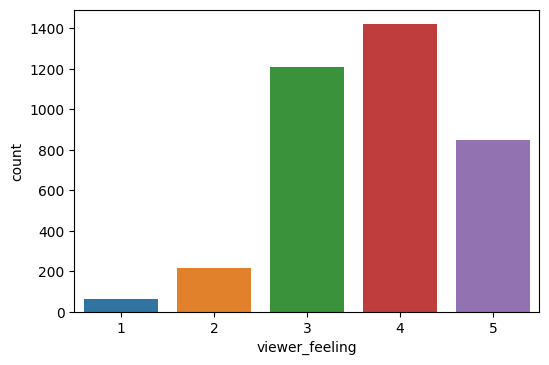

In [4]:
plt.figure(dpi = 100)
ax = sns.countplot(data = df, x = 'viewer_feeling')
plt.show()

# Data Preprocessing

1 - One Hot Encoding (Columns = venue, container)

In [31]:
label_df = pd.get_dummies(df[['container', 'venue']], prefix = {'container', 'venue'})

2 - Data Scaling (Columns = duration, no_ingredient)

In [30]:
df[["duration"]] = MinMaxScaler().fit_transform(df[["duration"]])
df[["no_ingredient"]] = MinMaxScaler().fit_transform(df[["no_ingredient"]])

3 - Define Features (X) And Data Values (Y)

In [28]:
input = np.array(df[['duration', 'no_ingredient', 'recipes']].join(label_df))
output = np.array(df[['viewer_feeling']])

# output = pd.get_dummies(df['viewer_feeling'], prefix = 'viewer_feeling')
# print(output)

input_train, input_test, output_train, output_test = train_test_split(input, np.ravel(output), test_size = 0.2, random_state = 101, stratify = output)

print(input.shape, output.shape)

(3757, 17) (3757, 1)


5 - Show all input features

In [27]:
df[['duration', 'no_ingredient', 'recipes']].join(label_df).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration            3757 non-null   float64
 1   no_ingredient       3757 non-null   float64
 2   recipes             3757 non-null   int64  
 3   container_bag       3757 non-null   uint8  
 4   container_bottle    3757 non-null   uint8  
 5   container_bowl      3757 non-null   uint8  
 6   container_box       3757 non-null   uint8  
 7   container_glass     3757 non-null   uint8  
 8   container_hands_on  3757 non-null   uint8  
 9   container_other     3757 non-null   uint8  
 10  container_plate     3757 non-null   uint8  
 11  container_pot       3757 non-null   uint8  
 12  container_tray      3757 non-null   uint8  
 13  venue_casual        3757 non-null   uint8  
 14  venue_fine          3757 non-null   uint8  
 15  venue_other         3757 non-null   uint8  
 16  venue_

# Model Building

In [32]:
# Create a SVM with linear kernel
clf_lin = svm.SVC(kernel = 'linear')
# Create a SVM with polynomial kernel
clf_poly = svm.SVC(kernel = 'poly')
# Create a SVM with RBF kernel
clf_rbf = svm.SVC(kernel = 'rbf')

In [33]:
# Train the model using the training sets with different type of kernels
clf_lin.fit(input_train, output_train) # Linear Kernel
clf_poly.fit(input_train, output_train) # Polynomial Kernel
clf_rbf.fit(input_train, output_train) # RBF Kernel

SVC()

In [34]:
# Predict the response for test dataset
lin_pred = clf_lin.predict(input_test)
poly_pred = clf_poly.predict(input_test)
rbf_pred = clf_rbf.predict(input_test)

In [35]:
lin_accuracy = accuracy_score(output_test, lin_pred)
lin_f1 = f1_score(output_test, lin_pred, average = 'weighted')
lin_clfrpt = classification_report(output_test, lin_pred, labels=np.unique(lin_pred))
print('Accuracy (Linear Kernel): ', "%.8f" % (lin_accuracy * 100))
print('F1 Score (Linear Kernel): ', "%.8f" % (lin_f1 * 100))
print(lin_clfrpt)

Accuracy (Linear Kernel):  40.42553191
F1 Score (Linear Kernel):  35.62155090
              precision    recall  f1-score   support

           3       0.40      0.72      0.51       242
           4       0.41      0.17      0.24       285
           5       0.42      0.48      0.45       170

   micro avg       0.40      0.44      0.42       697
   macro avg       0.41      0.46      0.40       697
weighted avg       0.41      0.44      0.38       697



In [36]:
poly_accuracy = accuracy_score(output_test, poly_pred)
poly_f1 = f1_score(output_test, poly_pred, average = 'weighted')
poly_clfrpt = classification_report(output_test, poly_pred, labels=np.unique(poly_pred))
print('Accuracy (Polynomial Kernel): ', "%.8f" % (poly_accuracy * 100))
print('F1 Score (Polynomial Kernel): ', "%.8f" % (poly_f1 * 100))
print(poly_clfrpt)

Accuracy (Polynomial Kernel):  42.81914894
F1 Score (Polynomial Kernel):  39.46231275
              precision    recall  f1-score   support

           3       0.42      0.65      0.51       242
           4       0.42      0.46      0.44       285
           5       0.52      0.19      0.28       170

   micro avg       0.43      0.46      0.44       697
   macro avg       0.45      0.44      0.41       697
weighted avg       0.44      0.46      0.43       697



In [38]:
rbf_accuracy = accuracy_score(output_test, rbf_pred)
rbf_f1 = f1_score(output_test, rbf_pred, average = 'weighted')
rbf_clfrpt = classification_report(output_test, rbf_pred, labels=np.unique(rbf_pred)) 
print('Accuracy (RBF Kernel): ', "%.8f" % (rbf_accuracy * 100))
print('F1 Score (RBF Kernel): ', "%.8f" % (rbf_f1 * 100))
print(rbf_clfrpt)

Accuracy (RBF Kernel):  42.81914894
F1 Score (RBF Kernel):  39.50827910
              precision    recall  f1-score   support

           3       0.42      0.66      0.51       242
           4       0.42      0.45      0.44       285
           5       0.52      0.20      0.29       170

   micro avg       0.43      0.46      0.44       697
   macro avg       0.45      0.44      0.41       697
weighted avg       0.44      0.46      0.43       697



Using Grid Search

In [39]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(input_train, output_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.396 total time=   0.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.384 total time=   0.6s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.376 total time=   0.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.381 total time=   0.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.373 total time=   0.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.388 total time=   0.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.381 total time=   0.6s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.389 total time=   0.6s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.388 total time=   0.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.386 total time=   0.6s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.378 total time=   0.6s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001], 'kernel': ['rbf']},
             verbose=3)

In [44]:
# print best parameter after tuning
print(grid.best_params_)

# print how the model looks after hyper-parameter tuning
print(grid.best_estimator_)
grid_predictions = grid.predict(input_test)
grid_accuracy = accuracy_score(output_test, grid_predictions)
grid_f1 = f1_score(output_test, grid_predictions, average = 'weighted')
grid_clfrpt = classification_report(output_test, grid_predictions, labels=np.unique(grid_predictions))
print('Accuracy (using Grid Search): ', "%.8f" % (grid_accuracy * 100))
print('F1 Score (using Grid Search): ', "%.8f" % (grid_f1 * 100))
print(grid_clfrpt)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.1)
Accuracy (using Grid Search):  42.28723404
F1 Score (using Grid Search):  39.31409181
              precision    recall  f1-score   support

           2       0.25      0.02      0.04        43
           3       0.42      0.57      0.48       242
           4       0.42      0.52      0.46       285
           5       0.50      0.18      0.27       170

   micro avg       0.42      0.43      0.43       740
   macro avg       0.40      0.32      0.31       740
weighted avg       0.43      0.43      0.40       740

